<a href="https://colab.research.google.com/github/Almonfrey/MAI-Course/blob/main/class_8_cross_validation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# UCI Heart Disease — MLP Balanced Model with Cross-Validation and Detailed Metrics

This notebook demonstrates building a balanced multilayer-perceptron (MLP) classifier for the **UCI Heart Disease (Cleveland)** dataset. It uses `sklearn`'s `MLPClassifier` and performs cross-validation. It reports accuracy, recall, precision, F1-score, loss function and AUC (area under ROC curve).

**Goals:**
- Provide a clean, well-documented notebook covering import, data loading, cleaning, preprocessing, modeling, evaluation, and interpretation.
- Use cross-validation for robust model assessment, reporting mean and standard deviation for each metric (train and validation splits).
- Compute all standard metrics on the held-out test set.
- Explain each step thoroughly: motivation, caveats, and best practices (especially for medical data).

---

## Notes on usage
- This notebook is ready to run in any Jupyter environment (Lab, Notebook, VS Code, Colab, etc.).
- It does not execute here — run the cells in your own environment to get results and plots.


## 1 — Imports and environment setup

### What is done?
- Import `pandas`, `numpy` for data handling.
- Import `sklearn` modules for splitting, preprocessing, modeling, cross-validation, and metric computation.
- Import `matplotlib` for plotting (if you wish to visualize ROC curves later).
- Set up warnings filter (optional: MLP can emit convergence warnings).

### Why these imports?
- **pandas / numpy**: essential for tabular data.
- **train_test_split, cross_val_score, StratifiedKFold**: ensure stratified splits and proper cross-validation (preserving class balance).
- **Pipeline / ColumnTransformer**: encapsulate preprocessing steps (fit only on training data to avoid leakage).
- **SimpleImputer, StandardScaler, OneHotEncoder**: standard preprocessing for missing values, scaling, encoding.
- **MLPClassifier**: flexible feed-forward neural net, suitable for capturing non-linear decision boundaries.
- **sklearn.metrics**: compute multiple evaluation metrics for robust assessment.


In [ ]:
# 1. Import libraries
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split, StratifiedKFold, cross_validate
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, log_loss
import matplotlib.pyplot as plt
import warnings

warnings.filterwarnings("ignore", category=UserWarning)


## 2 — Load and inspect the UCI Heart Disease (Cleveland) dataset

https://archive.ics.uci.edu/dataset/45/heart+disease

### Dataset notes
- The Cleveland dataset is a standard classification benchmark. The outcome (`target`) is 0 for no disease, and 1–4 for presence (different degrees). We'll convert this to binary (0 = no, 1 = yes).
- Missing values are represented by `?` in some columns (`ca`, `thal`).

What are the columns (features and labels?)
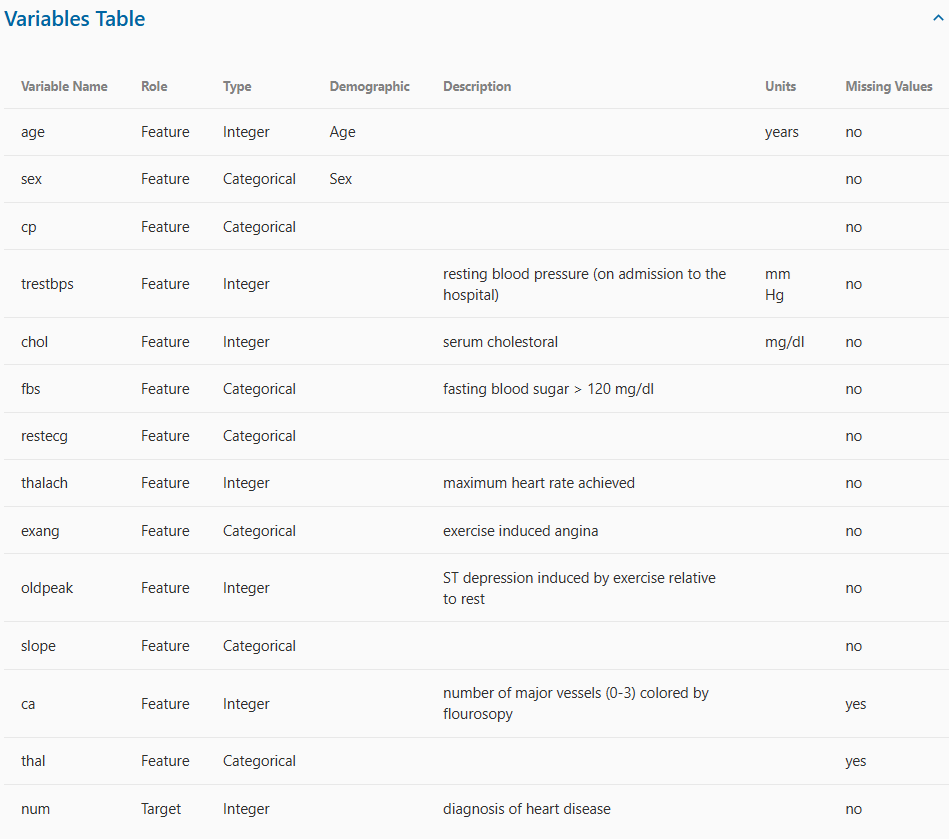

In [ ]:
# 2. Load the dataset
url = "https://archive.ics.uci.edu/ml/machine-learning-databases/heart-disease/processed.cleveland.data"
columns = [
    "age","sex","cp","trestbps","chol","fbs","restecg","thalach","exang",
    "oldpeak","slope","ca","thal","target"
]
df = pd.read_csv(url, names=columns)

# Quick look at the raw data
df.head()

## 3 — Data cleaning

### What is done?
- Replace `?` with `np.nan` for missing values.
- Convert all columns to numeric; any non-numeric becomes `NaN`.
- Convert `target` to binary: 0 (no disease), 1 (any disease: 1–4).
- Print missing value counts for transparency.

### Why?
- Many ML tools require numeric types; converting ensures correct preprocessing.
- Binary target simplifies the problem to disease presence/absence (most common clinical framing).
- Knowing missingness guides imputation choices.


In [ ]:
# 3. Clean missing values and convert types
df.replace("?", np.nan, inplace=True)
for col in df.columns:
    df[col] = pd.to_numeric(df[col], errors='coerce')

print("Missing values per column:\n", df.isnull().sum())

# Convert target to binary
df['target'] = df['target'].replace({1:1, 2:1, 3:1, 4:1})
# Optional: show class balance
print("Target class balance:\n", df['target'].value_counts(normalize=True))

## 4 — Feature/target separation

### What is done?
- Separate predictors (`X`) and outcome (`y`).
- This is a standard step for supervised learning.

In [ ]:
# 4. Split features and target
X = df.drop('target', axis=1)
y = df['target']

## 5 — Identify categorical and numerical columns

### What is done?
- Identify columns to be treated as categorical (for one-hot encoding).
- All others are treated as numerical.

### Why?
- Proper encoding/scaling improves neural network performance and prevents misleading relationships (e.g., treating categories as continuous).
- The columns chosen (`cp`, `restecg`, `slope`, `ca`, `thal`) are discrete/categorical by nature.

In [ ]:
# 5. Categorical and numerical columns
cat_cols = ['cp', 'restecg', 'slope', 'ca', 'thal']
num_cols = [col for col in X.columns if col not in cat_cols]


## 6 — Train/test split

### What is done?
- Split dataset into training and test sets (70%/30%), stratifying by outcome (`y`).
- Set a fixed random state for reproducibility.

### Why?
- Stratification preserves class balance, important for medical datasets (often imbalanced).
- The test set provides an unbiased evaluation after hyperparameter selection and cross-validation.

In [ ]:
# 6. Train/test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, stratify=y, random_state=42
)

## 7 — Build preprocessing pipeline

### What is done?
- Construct a `ColumnTransformer` to apply the right preprocessing to each column type (numerical/categorical).
- Numerical: impute missing values (mean), scale (zero mean, unit variance).
- Categorical: impute missing values (most frequent), one-hot encode.

### Why?
- Ensures consistent, reproducible preprocessing.
- Prevents information leakage from the test set.
- Proper scaling and encoding are crucial for neural network convergence and performance.

In [ ]:
# 7. Preprocessing pipeline
preprocessor = ColumnTransformer([
    ('num', Pipeline([
        ('imputer', SimpleImputer(strategy='mean')),
        ('scaler', StandardScaler())
    ]), num_cols),
    ('cat', Pipeline([
        ('imputer', SimpleImputer(strategy='most_frequent')),
        ('onehot', OneHotEncoder(handle_unknown='ignore'))
    ]), cat_cols)
])

## 8 — Define the balanced MLP model

### What is done?
- Specify an MLPClassifier with balanced settings:
  - `hidden_layer_sizes=(30,)` (single hidden layer, 30 neurons)
  - `alpha=0.01` (L2 regularization)
  - `solver='adam'`, `learning_rate_init=0.001`
  - `max_iter=300` (enough for convergence)
- Combine with preprocessing pipeline.

### Why?
- These settings are a reasonable default for small medical datasets, balancing capacity and regularization.
- The pipeline ensures all steps are fit only on training data during cross-validation.

In [ ]:
# 8. Balanced MLP pipeline
mlp = MLPClassifier(
    hidden_layer_sizes=(30,),
    alpha=0.01,
    learning_rate_init=0.001,
    solver='adam',
    max_iter=300,
    random_state=42
)

pipe = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', mlp)
])

## 9 — Cross-validation: average and std for metrics

### What is done?
- Perform 5-fold stratified cross-validation on the training set using `cross_validate`.
- Track multiple metrics: accuracy, precision, recall, F1-score, and ROC AUC.
- Report mean and standard deviation for each metric (train and validation splits).

### Why?
- Cross-validation provides a robust estimate of generalization (not just a single split).
- Using multiple metrics captures different aspects of performance:
  - **Accuracy**: overall rate of correct predictions.
  - **Recall (Sensitivity)**: ability to identify positive cases (important in medical contexts).
  - **Precision**: probability that a positive prediction is correct.
  - **F1-score**: harmonic mean of precision and recall (balances trade-off).
  - **ROC AUC**: ability to rank positives above negatives (threshold-independent).
- Reporting both mean and standard deviation shows stability and reliability of the model across splits.

In [ ]:
# 9. Cross-validation on train set
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
metrics = ['accuracy', 'precision', 'recall', 'f1', 'roc_auc', 'neg_log_loss']
cv_results = cross_validate(
    pipe, X_train, y_train,
    cv=cv,
    scoring=metrics,
    return_train_score=True
)

# Helper to print mean and std for each metric
def print_cv_table(results, metrics):
    print("\nCross-validation results (5 folds):")
    print(f"{'Metric':<12} {'Train Mean':>12} {'Train Std':>12} {'Val Mean':>12} {'Val Std':>12}")
    for m in metrics:
        train_scores = results[f'train_{m}']
        val_scores = results[f'test_{m}']
        print(f"{m:<12} {np.mean(train_scores):12.3f} {np.std(train_scores):12.3f} {np.mean(val_scores):12.3f} {np.std(val_scores):12.3f}")

print_cv_table(cv_results, metrics)

## 10 — Fit on train, evaluate on held-out test set

### What is done?
- Fit the pipeline on the whole training set (including cross-validation folds).
- Predict on the held-out test set.
- Compute and report accuracy, precision, recall, F1-score, and ROC AUC for the test set.

### Why?
- Test set evaluation gives an unbiased estimate of real-world performance after tuning/hyperparameter selection.
- Reporting all metrics highlights strengths/weaknesses (e.g., high accuracy but low recall = misses positives).


In [ ]:
# 10. Fit and evaluate on test set
pipe.fit(X_train, y_train)
y_pred = pipe.predict(X_test)
y_proba = pipe.predict_proba(X_test)[:, 1]

test_metrics = {
    'Accuracy': accuracy_score(y_test, y_pred),
    'Precision': precision_score(y_test, y_pred),
    'Recall': recall_score(y_test, y_pred),
    'F1-score': f1_score(y_test, y_pred),
    'ROC AUC': roc_auc_score(y_test, y_proba),
    'Neg Log Loss': -log_loss(y_test, y_proba)
}

print("\nTest set metrics:")
for k, v in test_metrics.items():
    print(f"{k:<10}: {v:.3f}")

## 11 — Interpreting the results & next steps

### What do the metrics tell us?
- **Accuracy**: Proportion of all correct predictions (positive and negative). May be misleading if classes are imbalanced.
- **Precision**: Of all predicted positives, what fraction were correct? High precision means few false positives.
- **Recall (Sensitivity)**: Of all actual positives, what fraction did we find? High recall means few false negatives (important in medical screening).
- **F1-score**: Balances precision and recall. Useful when both are important.
- **ROC AUC**: Measures the ability to rank positives above negatives across all thresholds. Useful for comparing models independent of chosen threshold.

### What next?
- If you need to improve recall (find more positives), try tuning the model (e.g., changing `alpha`, hidden layer size, or class_weight).
- If precision is low, it may mean the model is over-predicting positives (can adjust threshold or tune regularization).
- Consider other models (e.g., logistic regression, tree-based) for comparison.
- In medical contexts, sometimes recall (sensitivity) is prioritized over precision, depending on the application (screening vs. diagnosis).
- Always validate findings with external data and consider clinical relevance of each metric.

### Visualization (optional)
- You may plot ROC curves or confusion matrices for further insight.